## Example: Applying TigerTail to SerpRateAI Data

In this notebook, we apply the TigerTail library to the SerpRateAI data that can be downloaded from https://github.com/SerpRateAI/datasets. This repository contains a number of datasets related to processes that lead to gas bubble formation in rock at an Oman drilling site.

The eventual goal is to predict when the formation of bubbles occur using the other time series datasets. This notebook shows how to use TigerTail classes to help visualize patterns in the time series datasets leading up to a bubble formation event. The specific datasets used in this notebook are:

* bubbles.csv: contains the timestamps at which bubbles were detected
* daily_precipitation.csv: contains the amount of precipitation per day in the area (not cumulative)
* hourly_surface_pressure.csv: contains surface pressure measurements per hour (not cumulative)

First we import the necessary libraries and load in the bubble data:

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '../TT')
from tigertail import TimeFrame, TimeSeries, EventSeries

The bubbles dataset was constructed by using a detected bubble as a template and then used a matched filter template matching algorithm to find the other bubbles. The columns in the dataset are `similarity`, `template_id`, and `ones`. `template_id` was the id for the template used, which is just all 0's. `similarity` is the calculated correlation between the detected bubble and the template bubble. `ones` is just a column of 1's which is helpful for counting the number of bubbles over time for plotting or windowing purposes.

In [2]:
bubbles_path = '../data/serprate-ai/bubbles.csv'
bubbles_df = pd.read_csv(bubbles_path).set_index('time')
bubbles_df.index = pd.to_datetime(bubbles_df.index, format='ISO8601')
bubbles_df.index.name = None
bubbles_df = bubbles_df.tz_localize(None)
bubbles_df

,similarity,template_id,ones
2019-05-07 16:37:35.302001,0.800337,0,1
2019-05-17 00:56:44.213000,0.801590,0,1
2019-05-18 11:45:45.948000,0.948577,0,1
2019-05-18 11:47:16.325000,0.962242,0,1
2019-05-18 11:47:54.450000,0.964003,0,1
...,...,...,...
2020-02-02 05:41:40.738000,0.811049,0,1
2020-02-02 08:03:25.875000,0.804105,0,1
2020-02-02 12:32:29.838000,0.810579,0,1
2020-02-02 22:43:12.641000,0.812358,0,1


/Users/cassandralem/Desktop/TigerTail/.conda/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


<Axes: >

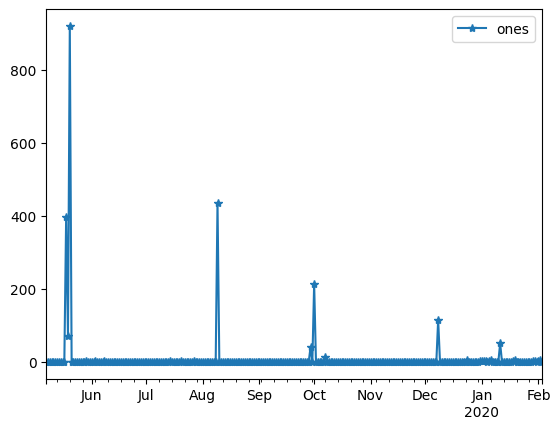

In [3]:
# drop the template_id column since it's not necessary for this demonstration

bubbles_es = EventSeries(bubbles_df.drop(columns=['template_id']), agg_func=np.sum)
bubbles_es.window('1D').plot(y='ones', marker='*')

Now we load the daily precipitation dataset into a DataFrame. We convert the timestamp column values to datetime objects and then set that column as the index.

In [4]:
daily_precip_path = '../data/serprate-ai/daily_precipitation.csv'
daily_precip_df = pd.read_csv(daily_precip_path).set_index('system:time_start')
daily_precip_df.index = pd.to_datetime(daily_precip_df.index)
daily_precip_df.index.name = None
# daily_precip_df = daily_precip_df.tz_localize(None)
daily_precip_df

,total_precipitation_sum
2019-01-01,0.0
2019-01-02,0.0
2019-01-03,0.0
2019-01-04,0.0
2019-01-05,0.0
...,...
2020-02-25,0.0
2020-02-26,0.0
2020-02-27,0.0
2020-02-28,0.0


Now we create a TimeSeries object with the created DataFrame and demonstrate the use of the TimeSeries window function. We window the data by finding the averages over periods of 1 week and plot the results.

<Axes: >

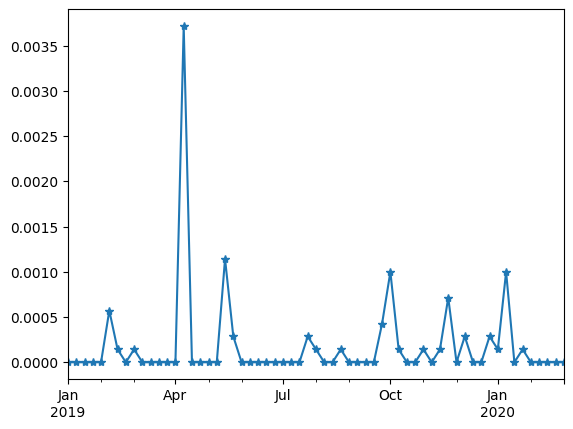

In [5]:
daily_precip_ts = TimeSeries(daily_precip_df, agg_func=np.mean)
daily_precip_ts.window('1W').plot(marker='*')

In [6]:
daily_precip_ts.window('1D')

2019-01-01    0.0
2019-01-02    0.0
2019-01-03    0.0
2019-01-04    0.0
2019-01-05    0.0
             ... 
2020-02-25    0.0
2020-02-26    0.0
2020-02-27    0.0
2020-02-28    0.0
2020-02-29    0.0
Freq: D, Length: 425, dtype: float64

We do the same process with the hourly surface pressure dataset, but instead window the data according to 1 day intervals:

In [7]:
hourly_sp_path = '../data/serprate-ai/hourly_surface_pressure.csv'
hourly_sp_df = pd.read_csv(hourly_sp_path).set_index('datetime')
hourly_sp_df.index.name = None
hourly_sp_df.index = pd.to_datetime(hourly_sp_df.index)
hourly_sp_df = hourly_sp_df.tz_localize(None)
hourly_sp_df

,surface_pressure
2017-01-01 00:00:00,96536.368
2017-01-01 01:00:00,96553.223
2017-01-01 02:00:00,96599.012
2017-01-01 03:00:00,96674.992
2017-01-01 04:00:00,96747.476
...,...
2020-12-31 19:00:00,96888.352
2020-12-31 20:00:00,96892.005
2020-12-31 21:00:00,96861.655
2020-12-31 22:00:00,96875.097


<Axes: >

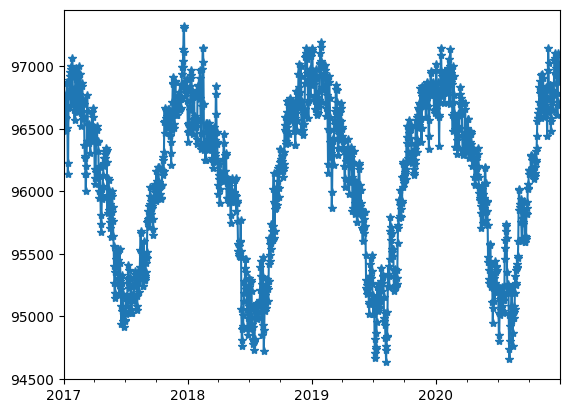

In [8]:
hourly_sp_ts = TimeSeries(hourly_sp_df, agg_func=np.mean)
hourly_sp_ts.window('1D').plot(marker='*')

Now we can create a TimeFrame object using the bubble EventSeries object and two TimeSeries objects we already created.

In [9]:
tf = TimeFrame()
tf['bubbles_es'] = bubbles_es
tf['daily_precip_ts'] = daily_precip_ts
tf['hourly_sp_ts'] = hourly_sp_ts

Then we can use the TimeFrame window function to window all 3 datasets according to 1 day intervals (but using their own object-specific aggregation functions, so we have the daily counts of bubbles and daily averages of precipitation and surface pressure):

In [10]:
tf_day_window = tf.window('1D')
tf_day_window

/Users/cassandralem/Desktop/TigerTail/.conda/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,similarity,ones,total_precipitation_sum,surface_pressure
2017-01-01,0.0,0.0,0.0,96671.014625
2017-01-02,0.0,0.0,0.0,96779.818708
2017-01-03,0.0,0.0,0.0,96759.870500
2017-01-04,0.0,0.0,0.0,96655.596208
2017-01-05,0.0,0.0,0.0,96577.570625
...,...,...,...,...
2020-12-27,0.0,0.0,0.0,97110.352208
2020-12-28,0.0,0.0,0.0,96998.292167
2020-12-29,0.0,0.0,0.0,96908.148167
2020-12-30,0.0,0.0,0.0,96925.027333


We visualize the windowing of the 3 datasets:

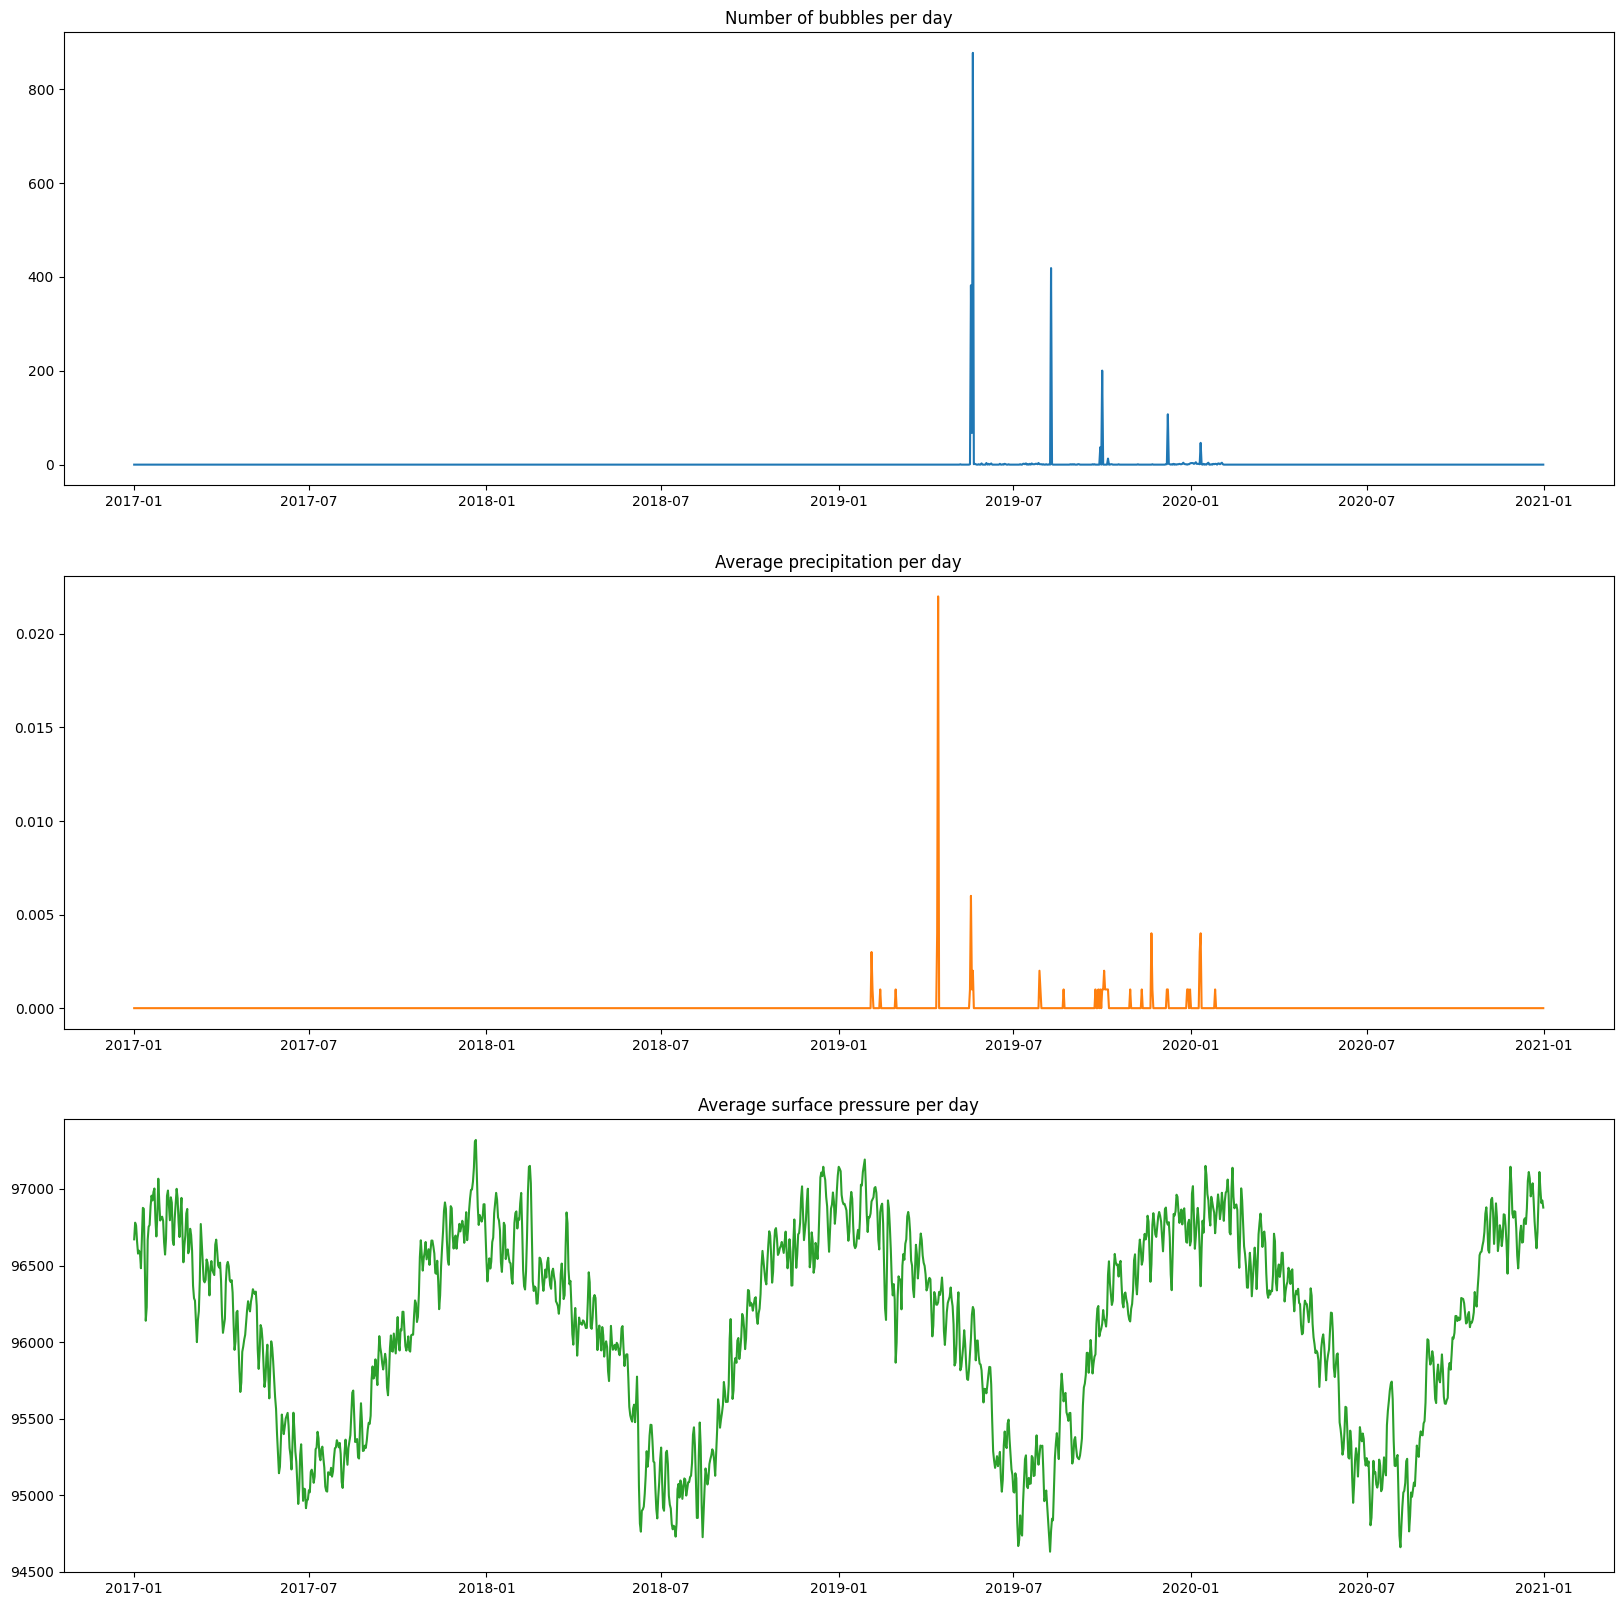

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
axs[0].plot(tf_day_window.index, tf_day_window['similarity'])
axs[0].set_title('Number of bubbles per day')
axs[1].plot(tf_day_window.index, tf_day_window['total_precipitation_sum'], 'tab:orange')
axs[1].set_title('Average precipitation per day')
axs[2].plot(tf_day_window.index, tf_day_window['surface_pressure'], 'tab:green')
axs[2].set_title('Average surface pressure per day')
plt.show()

Let's view part of the plot where the bubble count goes up closer.

In [12]:
shorter_period_df = tf_day_window.loc['2019-01-01':'2020-02-28']
shorter_period_df

,similarity,ones,total_precipitation_sum,surface_pressure
2019-01-01,0.0,0.0,0.0,97144.518375
2019-01-02,0.0,0.0,0.0,97132.137125
2019-01-03,0.0,0.0,0.0,97115.655250
2019-01-04,0.0,0.0,0.0,96960.913083
2019-01-05,0.0,0.0,0.0,96918.480292
...,...,...,...,...
2020-02-24,0.0,0.0,0.0,96773.375458
2020-02-25,0.0,0.0,0.0,96625.853250
2020-02-26,0.0,0.0,0.0,96574.696375
2020-02-27,0.0,0.0,0.0,96496.441875


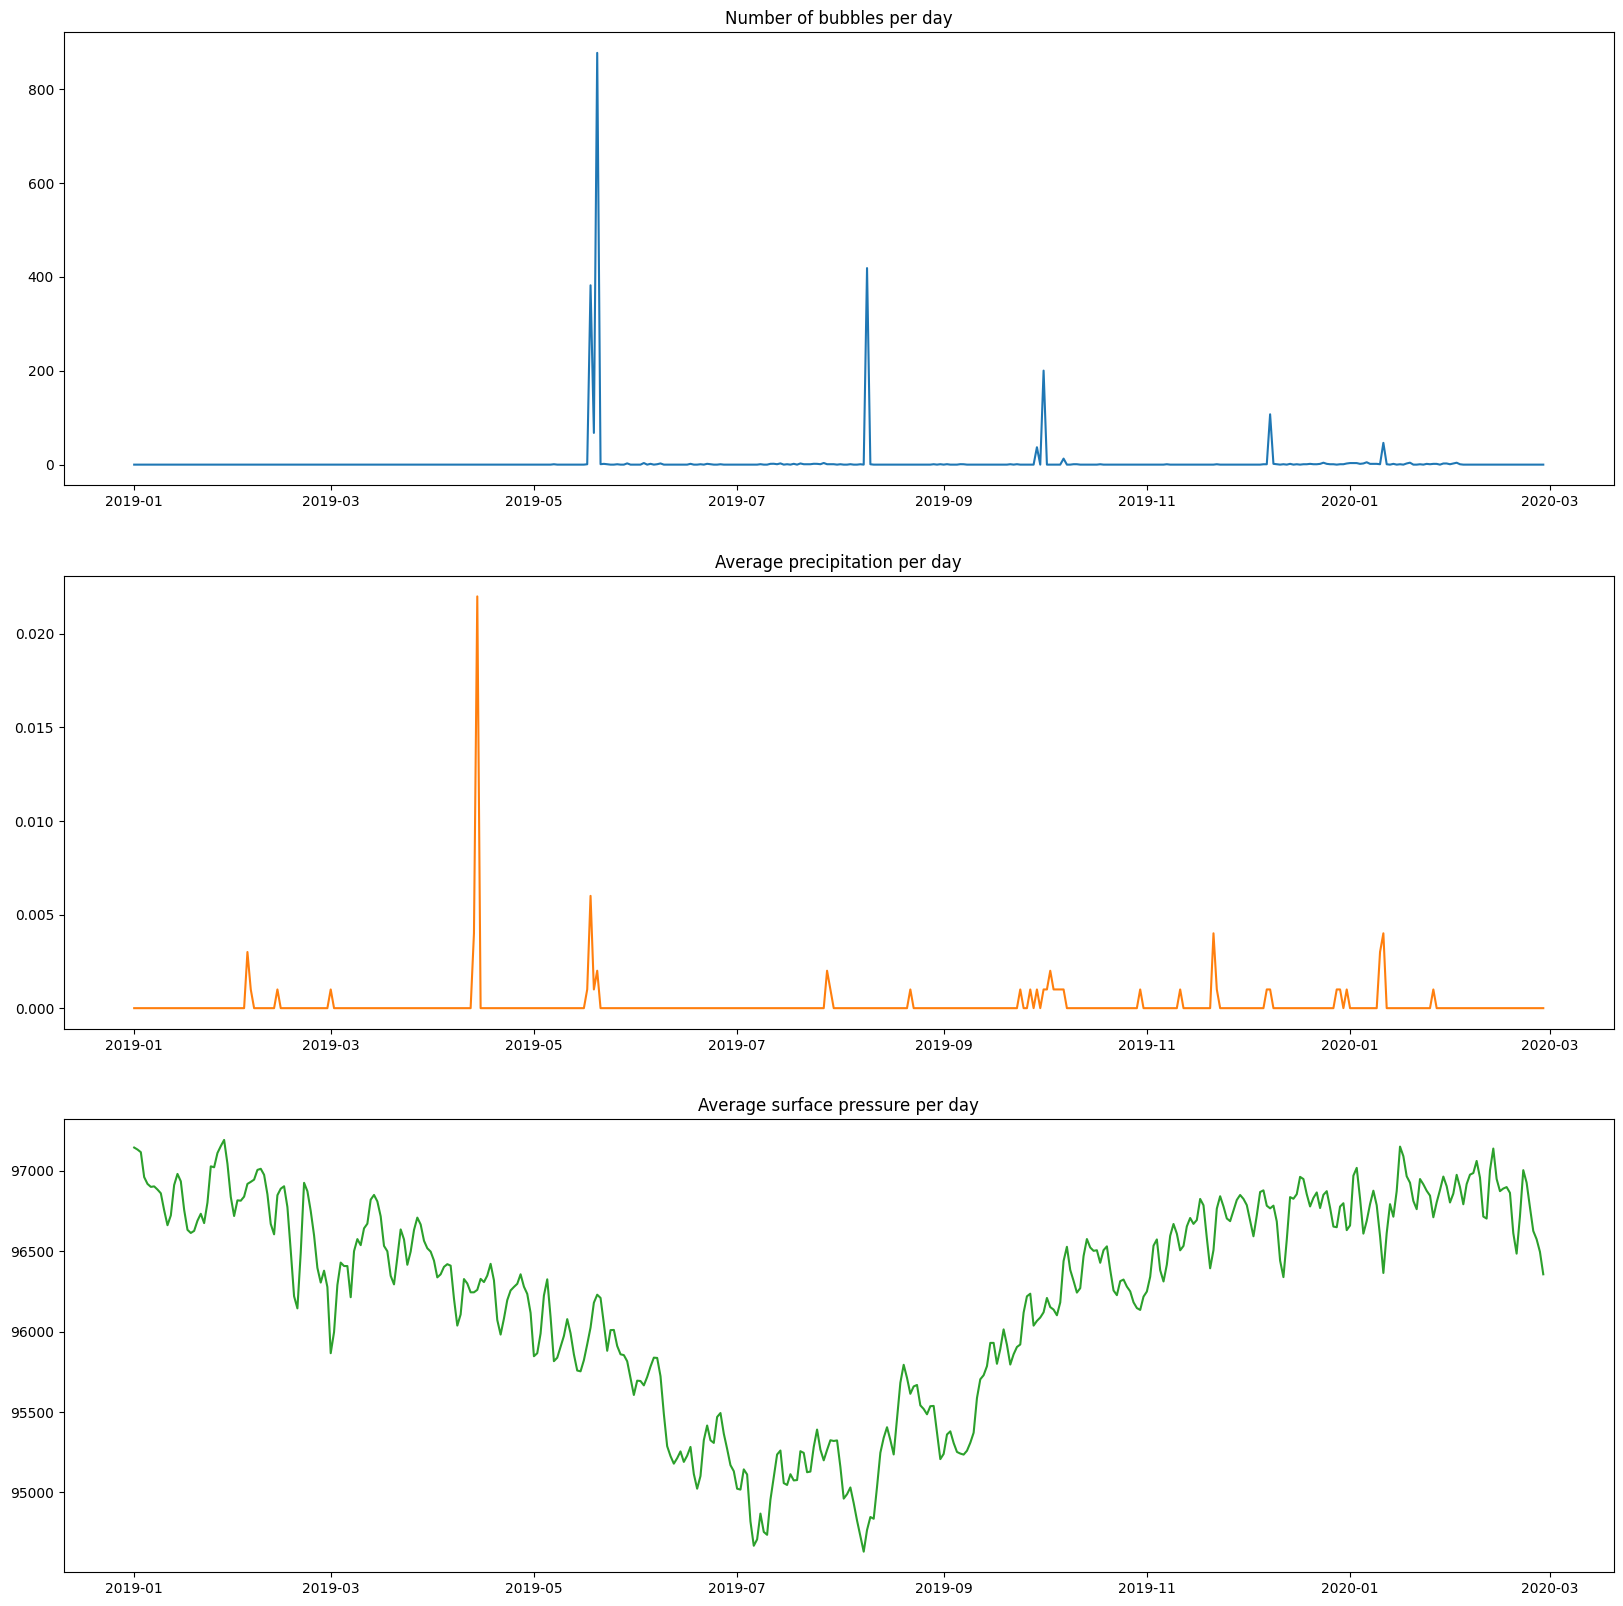

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
axs[0].plot(shorter_period_df.index, shorter_period_df['similarity'])
axs[0].set_title('Number of bubbles per day')
axs[1].plot(shorter_period_df.index, shorter_period_df['total_precipitation_sum'], 'tab:orange')
axs[1].set_title('Average precipitation per day')
axs[2].plot(shorter_period_df.index, shorter_period_df['surface_pressure'], 'tab:green')
axs[2].set_title('Average surface pressure per day')
plt.show()

We can see days at which there are a large number of bubbles that formed, so we would want to look at trends in the other time series datasets, including the precipitation and surface pressure data, leading up to or surrounding days with a large number of bubbles. We now demonstrate how to use the TimeFrame window function to window the precipitation and surface pressure data according to the bubble event timestamps.

In [14]:
ns_window_df = tf.window(freq=bubbles_es)
ns_window_df

,similarity,ones,total_precipitation_sum,surface_pressure
2019-05-07 16:37:35.302001,0.800337,1,0.000000,0.000000
2019-05-17 00:56:44.213000,0.801590,1,0.000252,96162.925114
2019-05-18 11:45:45.948000,0.948577,1,0.006000,95953.806629
2019-05-18 11:47:16.325000,0.962242,1,0.000000,0.000000
2019-05-18 11:47:54.450000,0.964003,1,0.000000,0.000000
...,...,...,...,...
2020-02-02 05:41:40.738000,0.811049,1,0.000000,97002.704800
2020-02-02 08:03:25.875000,0.804105,1,0.000000,97063.475333
2020-02-02 12:32:29.838000,0.810579,1,0.000000,96804.011000
2020-02-02 22:43:12.641000,0.812358,1,0.000000,97010.311500


Now we can make a plot to see what combinations of average precipitation and surface pressure are observed during the intervals in between bubble events.

<Axes: xlabel='total_precipitation_sum', ylabel='surface_pressure'>

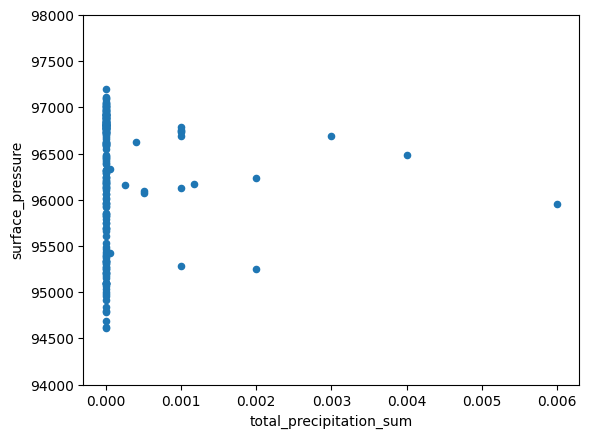

In [17]:
ns_window_df.plot(x='total_precipitation_sum', y='surface_pressure', kind='scatter', ylim=[94000, 98000])